In [62]:
import numpy as np
import matplotlib.pylab as plt
from copy import copy as cp
%matplotlib notebook

# Simulation space dimensions, etc.
nx = 251
ny = 251
xmax = 2000.0 # micrometers
ymax = 2000.0
x = np.linspace(0,xmax,nx); dx = x[1]-x[0]; print 'dx', dx
y = np.linspace(0,ymax,ny); dy = y[1]-y[0]
nxmid = int(nx/2); print 'nxmid =', nxmid; print 'x(nxmid) =',x[nxmid]
nymid = int(ny/2)
x = x-x[nxmid]
y = y-y[nymid]

# Define the box in the middle
Ldesired = 35.
boxrad = int(Ldesired/dx)
L = boxrad*dx; print  'L =', L
ixbox = [ix for ix in range(nxmid-boxrad,nxmid+boxrad)]; #print ixbox
iybox = [iy for iy in range(nymid-boxrad,nymid+boxrad)]; #print iybox

ixbot = min(ixbox); #print ixbot
ixtop = max(ixbox); #print ixtop
iylft = min(iybox); #print iylft
iyrgt = max(iybox); #rint iyrgt

D_SI_300 = 24.0e-6 # m^2/s
D_300 = D_SI_300 * 1e6  # um^2/us
Temp = 260.0
Pressure = .2
alpha = 2.072
D = D_300*(Temp/300)**alpha/(Pressure/1.0); print D_300, D

udirichlet = 1.0
ubox = 0.0

gneumann_nu_kin = D/((nx-1)*dx**2); print 'gneumann_kin', gneumann_nu_kin 
nu_kin_ml = 0.1633333333
kfactor = gneumann_nu_kin/nu_kin_ml; print 'kfactor', kfactor
alphasigma = .36; print 'alpha*sigma', alphasigma
gneumann = kfactor * nu_kin_ml; print 'gneumann', gneumann

def fillin(un,ixbox,iybox):
    border = cp(un[ixbox[0]-1,iybox[0]])
    for ix in ixbox:        
        for iy in iybox:
            un[ix,iy] = border
    return un

# initialize unow and u as ones/zeros matrices 
u0 = np.ones([nx, ny])*udirichlet # old u values
u0 = fillin(u0,ixbox, iybox)
u1 = cp(u0)



dx 8.0
nxmid = 125
x(nxmid) = 1000.0
L = 32.0
24.0 89.2094338602
gneumann_kin 0.00557558961626
kfactor 0.0341362629637
alpha*sigma 0.36
gneumann 0.00557558961626


In [63]:
dx2 = dx**2
dy2 = dy**2
dt = (dx2+dy2)/D/10; print dt
Dxeff = D*dt/dx2
Dyeff = D*dt/dy2
gneumanneff = gneumann*dt; print 'gneumann effective', gneumanneff

def propagate(u0_orig):
    
    u0 = cp(u0_orig)
    un = np.zeros(np.shape(u0))
#     un[1:-1, 1:-1] = u0[1:-1, 1:-1] + dt * D * ( \
#     (u0[2:, 1:-1] - 2*u0[1:-1, 1:-1] + u0[:-2, 1:-1])/dx2 + \
#     (u0[1:-1, 2:] - 2*u0[1:-1, 1:-1] + u0[1:-1, :-2])/dy2 )
    un[1:-1, 1:-1] = u0[1:-1, 1:-1] + ( \
    (u0[2:, 1:-1] - 2*u0[1:-1, 1:-1] + u0[:-2, 1:-1])*Dxeff + \
    (u0[1:-1, 2:] - 2*u0[1:-1, 1:-1] + u0[1:-1, :-2])*Dyeff )

    # Dirichlet outer boundary
    un[[0,-1],:]=udirichlet
    un[:,[0,-1]]=udirichlet
    
    #print 'after diffusion'
    #print un.T
    
#     # Dirichlet inner boundary
#     for ix in ixbox:
#         for iy in iybox:
#             un[ix,iy] = ubox
            
    # Neumann inner boundary
    #print ixbot-1
    #print iybox
    #print u0[ixbot-2,iybox], u0[ixbot-1,iybox]
    un[ixbot-1,iybox] = u0[ixbot-1,iybox] +(u0[ixbot-2,iybox] - u0[ixbot-1,iybox])*Dxeff -gneumanneff
    un[ixtop+1,iybox] = u0[ixtop+1,iybox] +(u0[ixtop+2,iybox] - u0[ixtop+1,iybox])*Dxeff -gneumanneff
    un[ixbox,iylft-1] = u0[ixbox,iylft-1] +(u0[ixbox,iylft-2] - u0[ixbox,iylft-1])*Dxeff -gneumanneff
    un[ixbox,iyrgt+1] = u0[ixbox,iyrgt+1] +(u0[ixbox,iyrgt+2] - u0[ixbox,iyrgt+1])*Dxeff -gneumanneff
    
    #print 'after Neumann'
    #print un.T
    
    # Also zero-out inside the box (this is just aesthetic)
    un = fillin(un,ixbox, iybox)
    
    return un


0.14348258302
gneumann effective 0.0008


<IPython.core.display.Javascript object>


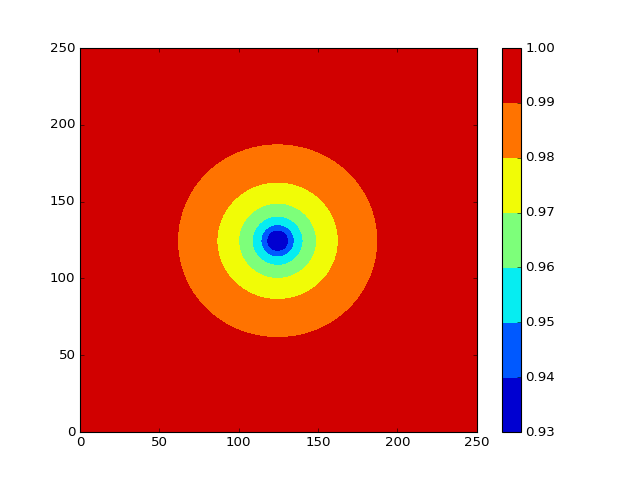

In [64]:
# Propagate forward
un = propagate(u0)
for i in range(15000):
    un = propagate(un)
plt.figure()
CS = plt.contourf(un)
plt.colorbar(CS)

<IPython.core.display.Javascript object>


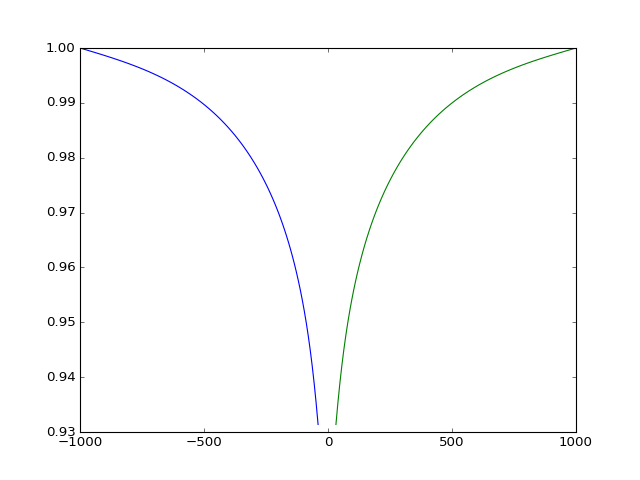

<IPython.core.display.Javascript object>


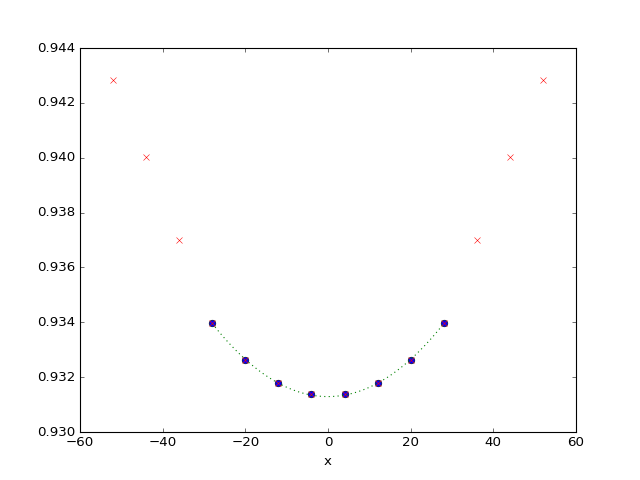

c_r = 0.260363898771
[  3.39575712e-06  -8.66464336e-09   9.31290983e-01]


In [65]:
# Show slices through the result

# Just a slice down the middle
plt.figure()
plt.plot(x[:ixbot],un[:ixbot,nymid])
plt.plot(x[ixtop+1:],un[ixtop+1:,nymid])

# Now a slice just across one of the box surfaces
plt.figure()
#uscaled = un[ixbox,nymid+boxrad]/max(un[ixbox,nymid+boxrad])
uscaled = un[ixbox,nymid+boxrad]
print 'c_r =', (max(uscaled)-min(uscaled))*100
xshifted = x[ixbox]-x[nxmid]+dx/2
plt.plot(xshifted,uscaled,'o')
p = np.polyfit(xshifted,uscaled,2); print p
xshifted_theory = np.linspace(min(xshifted),max(xshifted))
plt.plot(xshifted_theory,np.polyval(p,xshifted_theory),':')

iextend = 3
bigixbox = [ix for ix in range(nxmid-boxrad-iextend,nxmid+boxrad+iextend)]
biguscaled = un[bigixbox,nymid+boxrad]
bigxshifted = x[bigixbox]-x[nxmid]+dx/2
plt.plot(bigxshifted,biguscaled,'x')
plt.xlabel('x')
# plt.xlim([-L*1.,L*1.1])
